In [21]:
import matplotlib
import numpy as np
import os
import sys
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
from copy import deepcopy
import galsim

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.lenses import lens_util
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import survey_sim
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure

In [23]:
lenses = lens_util.get_detectable_lenses(config.machine.pipeline_dir, limit=100, with_subhalos=True)

100%|██████████| 100/100 [00:01<00:00, 54.15it/s]


In [24]:
lens = SampleStrongLens()
roman = Roman()

band = 'F106'
scene_size = 5  # arcsec
oversample = 5
config = {'sca': 1,
          'sca_position': (2048, 2048)}
exposure_time = 146

rng = galsim.UniformDeviate(42)

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band


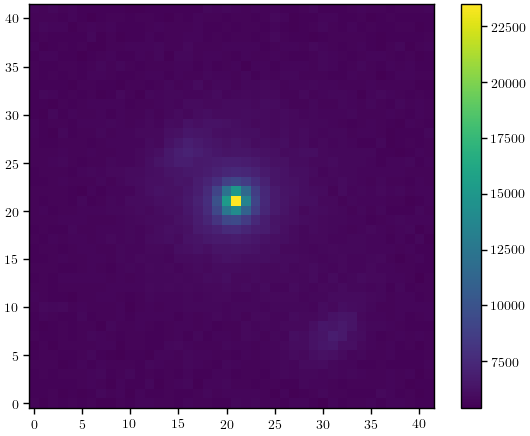

In [25]:
lens_1 = deepcopy(lens)
synth_1 = SyntheticImage(lens_1, roman, band=band, arcsec=scene_size, oversample=oversample, **config)
exposure_1 = Exposure(synth_1, exposure_time=146, rng=rng, **config, return_noise=True)

plt.imshow(exposure_1.exposure)
plt.colorbar()
plt.show()

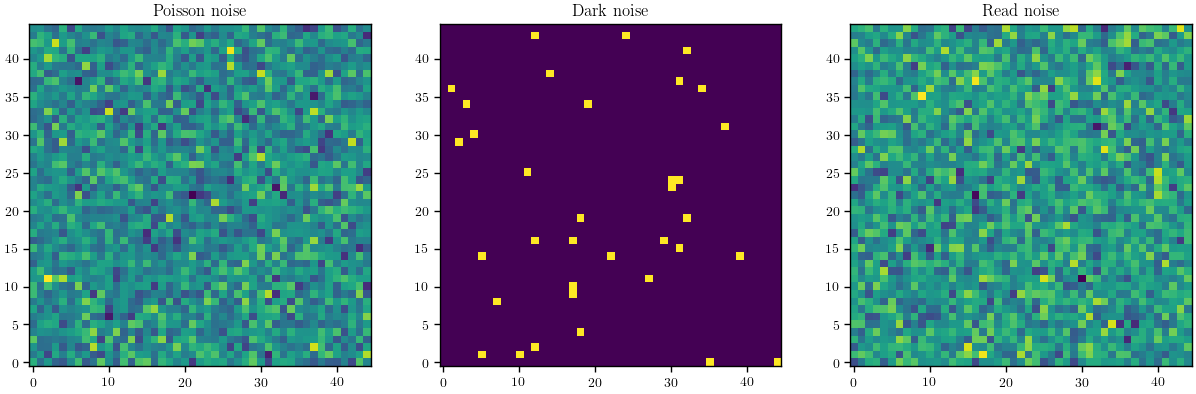

In [26]:
poisson_noise = exposure_1.poisson_noise
dark_noise = exposure_1.dark_noise
read_noise = exposure_1.read_noise

_, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(poisson_noise.array)
ax[0].set_title('Poisson noise')
ax[1].imshow(dark_noise.array)
ax[1].set_title('Dark noise')
ax[2].imshow(read_noise.array)
ax[2].set_title('Read noise')
plt.show()

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens SAMPLE by Roman in F106 band


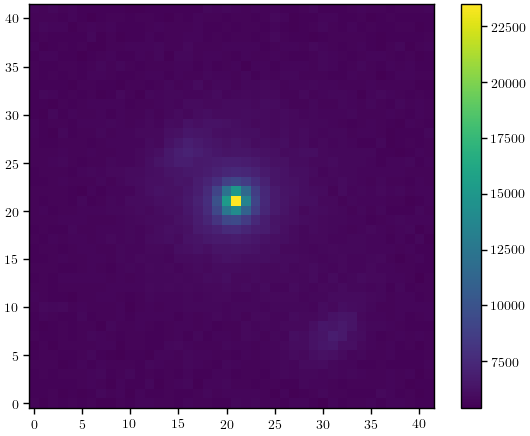

In [27]:
lens_2 = deepcopy(lens)
synth_2 = SyntheticImage(lens_2, roman, band=band, arcsec=scene_size, oversample=oversample, **config)
exposure_2 = Exposure(synth_2, exposure_time=146, rng=rng, **config, poisson_noise=poisson_noise, dark_noise=dark_noise,
                      read_noise=read_noise)

plt.imshow(exposure_2.exposure)
plt.colorbar()
plt.show()

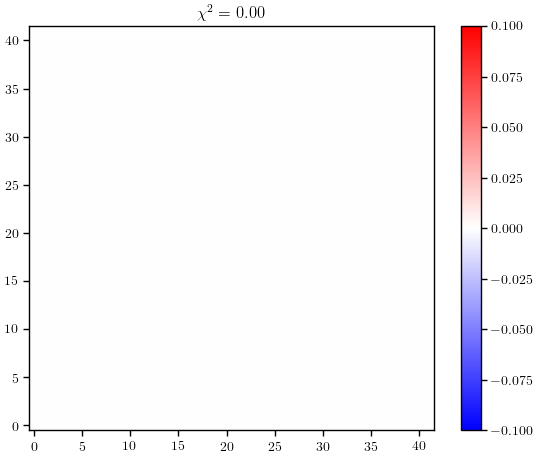

In [28]:
residual = exposure_2.exposure - exposure_1.exposure
chi_squared = stats.chi_square(observed=exposure_2.exposure, expected=exposure_1.exposure)

vmax = np.max(np.abs(residual))
plt.imshow(residual, cmap='bwr', vmin=-vmax, vmax=vmax)
plt.colorbar()
plt.title(r'$\chi^2=$ ' + f'{chi_squared:.2f}')
plt.show()

In [29]:
for lens in tqdm(lenses):
    lens_1 = deepcopy(lens)
    synth_1 = SyntheticImage(lens_1, roman, band=band, arcsec=scene_size, oversample=oversample, **config)
    exposure_1 = Exposure(synth_1, exposure_time=146, rng=rng, **config, return_noise=True)

    poisson_noise = exposure_1.poisson_noise
    dark_noise = exposure_1.dark_noise
    read_noise = exposure_1.read_noise

    lens_2 = deepcopy(lens)
    synth_2 = SyntheticImage(lens_2, roman, band=band, arcsec=scene_size, oversample=oversample, **config)
    exposure_2 = Exposure(synth_2, exposure_time=146, rng=rng, **config, poisson_noise=poisson_noise,
                          dark_noise=dark_noise, read_noise=read_noise)

    residual = exposure_2.exposure - exposure_1.exposure
    chi_squared = stats.chi_square(observed=exposure_2.exposure, expected=exposure_1.exposure)

    assert chi_squared == 0.

  0%|          | 0/100 [00:00<?, ?it/s]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00009895 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00009895 by Roman in F106 band


  1%|          | 1/100 [00:00<00:21,  4.54it/s]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005970 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


  2%|▏         | 2/100 [00:01<01:47,  1.09s/it]

Initialized SyntheticImage for StrongLens 00005970 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003314 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


  3%|▎         | 3/100 [00:02<01:28,  1.10it/s]

Initialized SyntheticImage for StrongLens 00003314 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000164 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


  5%|▌         | 5/100 [00:07<02:38,  1.67s/it]

Initialized SyntheticImage for StrongLens 00000164 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003156 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003156 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001808 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


  6%|▌         | 6/100 [00:08<02:08,  1.37s/it]

Initialized SyntheticImage for StrongLens 00001808 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004672 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


  7%|▋         | 7/100 [00:17<05:48,  3.75s/it]

Initialized SyntheticImage for StrongLens 00004672 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000854 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


  8%|▊         | 8/100 [00:17<04:01,  2.62s/it]

Initialized SyntheticImage for StrongLens 00000854 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004184 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


  9%|▉         | 9/100 [00:17<02:52,  1.89s/it]

Initialized SyntheticImage for StrongLens 00004184 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008277 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 10%|█         | 10/100 [00:19<02:57,  1.97s/it]

Initialized SyntheticImage for StrongLens 00008277 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000927 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 11%|█         | 11/100 [00:21<02:39,  1.79s/it]

Initialized SyntheticImage for StrongLens 00000927 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001306 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 12%|█▏        | 12/100 [00:21<01:55,  1.31s/it]

Initialized SyntheticImage for StrongLens 00001306 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007497 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 13%|█▎        | 13/100 [00:22<01:37,  1.12s/it]

Initialized SyntheticImage for StrongLens 00007497 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008442 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 14%|█▍        | 14/100 [00:25<02:36,  1.82s/it]

Initialized SyntheticImage for StrongLens 00008442 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007082 by Roman in F106 band


 15%|█▌        | 15/100 [00:25<01:57,  1.38s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007082 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00009624 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 16%|█▌        | 16/100 [00:31<03:52,  2.77s/it]

Initialized SyntheticImage for StrongLens 00009624 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008173 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 17%|█▋        | 17/100 [00:32<03:00,  2.17s/it]

Initialized SyntheticImage for StrongLens 00008173 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000240 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 18%|█▊        | 18/100 [00:39<04:48,  3.52s/it]

Initialized SyntheticImage for StrongLens 00000240 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007681 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 19%|█▉        | 19/100 [00:41<04:12,  3.12s/it]

Initialized SyntheticImage for StrongLens 00007681 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004090 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 20%|██        | 20/100 [00:42<03:12,  2.40s/it]

Initialized SyntheticImage for StrongLens 00004090 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008898 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008898 by Roman in F106 band


 21%|██        | 21/100 [00:42<02:17,  1.73s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006619 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006619 by Roman in F106 band


 22%|██▏       | 22/100 [00:42<01:39,  1.28s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001884 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 23%|██▎       | 23/100 [00:45<02:10,  1.70s/it]

Initialized SyntheticImage for StrongLens 00001884 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005851 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 24%|██▍       | 24/100 [00:46<01:49,  1.44s/it]

Initialized SyntheticImage for StrongLens 00005851 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002943 by Roman in F106 band


 25%|██▌       | 25/100 [00:46<01:23,  1.12s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002943 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003002 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 26%|██▌       | 26/100 [00:47<01:12,  1.02it/s]

Initialized SyntheticImage for StrongLens 00003002 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008785 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 27%|██▋       | 27/100 [00:47<01:01,  1.19it/s]

Initialized SyntheticImage for StrongLens 00008785 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004826 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 28%|██▊       | 28/100 [00:47<00:47,  1.52it/s]

Initialized SyntheticImage for StrongLens 00004826 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005165 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 29%|██▉       | 29/100 [00:49<01:10,  1.01it/s]

Initialized SyntheticImage for StrongLens 00005165 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003044 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 30%|███       | 30/100 [00:50<01:14,  1.07s/it]

Initialized SyntheticImage for StrongLens 00003044 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008202 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 31%|███       | 31/100 [00:51<01:03,  1.08it/s]

Initialized SyntheticImage for StrongLens 00008202 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001245 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 32%|███▏      | 32/100 [00:52<00:55,  1.24it/s]

Initialized SyntheticImage for StrongLens 00001245 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003103 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 33%|███▎      | 33/100 [00:59<02:57,  2.65s/it]

Initialized SyntheticImage for StrongLens 00003103 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002683 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002683 by Roman in F106 band


 34%|███▍      | 34/100 [00:59<02:10,  1.98s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00009704 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 35%|███▌      | 35/100 [00:59<01:35,  1.46s/it]

Initialized SyntheticImage for StrongLens 00009704 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005707 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 37%|███▋      | 37/100 [01:00<00:50,  1.24it/s]

Initialized SyntheticImage for StrongLens 00005707 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000121 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000121 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 38%|███▊      | 38/100 [01:00<00:40,  1.55it/s]

Initialized SyntheticImage for StrongLens 00003094 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003094 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002659 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 39%|███▉      | 39/100 [01:04<01:51,  1.83s/it]

Initialized SyntheticImage for StrongLens 00002659 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006774 by Roman in F106 band


 40%|████      | 40/100 [01:05<01:22,  1.38s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006774 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005573 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 41%|████      | 41/100 [01:07<01:32,  1.56s/it]

Initialized SyntheticImage for StrongLens 00005573 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005307 by Roman in F106 band


 42%|████▏     | 42/100 [01:07<01:10,  1.21s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005307 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003536 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 43%|████▎     | 43/100 [01:09<01:20,  1.42s/it]

Initialized SyntheticImage for StrongLens 00003536 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002395 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 44%|████▍     | 44/100 [01:19<03:39,  3.92s/it]

Initialized SyntheticImage for StrongLens 00002395 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004729 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 45%|████▌     | 45/100 [01:19<02:34,  2.82s/it]

Initialized SyntheticImage for StrongLens 00004729 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005158 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 46%|████▌     | 46/100 [01:21<02:13,  2.46s/it]

Initialized SyntheticImage for StrongLens 00005158 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002346 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 47%|████▋     | 47/100 [01:21<01:39,  1.88s/it]

Initialized SyntheticImage for StrongLens 00002346 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000298 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 49%|████▉     | 49/100 [01:22<00:53,  1.06s/it]

Initialized SyntheticImage for StrongLens 00000298 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002971 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002971 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003280 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 50%|█████     | 50/100 [01:34<03:41,  4.42s/it]

Initialized SyntheticImage for StrongLens 00003280 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006983 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 51%|█████     | 51/100 [01:36<03:05,  3.78s/it]

Initialized SyntheticImage for StrongLens 00006983 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003009 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 52%|█████▏    | 52/100 [01:37<02:18,  2.90s/it]

Initialized SyntheticImage for StrongLens 00003009 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006938 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 53%|█████▎    | 53/100 [01:38<01:46,  2.27s/it]

Initialized SyntheticImage for StrongLens 00006938 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007113 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 54%|█████▍    | 54/100 [01:38<01:16,  1.67s/it]

Initialized SyntheticImage for StrongLens 00007113 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005807 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 55%|█████▌    | 55/100 [01:39<00:55,  1.24s/it]

Initialized SyntheticImage for StrongLens 00005807 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007508 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 56%|█████▌    | 56/100 [01:39<00:50,  1.16s/it]

Initialized SyntheticImage for StrongLens 00007508 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007439 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 57%|█████▋    | 57/100 [01:43<01:26,  2.00s/it]

Initialized SyntheticImage for StrongLens 00007439 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007628 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 58%|█████▊    | 58/100 [01:44<01:07,  1.61s/it]

Initialized SyntheticImage for StrongLens 00007628 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001247 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 59%|█████▉    | 59/100 [01:46<01:02,  1.53s/it]

Initialized SyntheticImage for StrongLens 00001247 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000560 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 60%|██████    | 60/100 [01:46<00:50,  1.25s/it]

Initialized SyntheticImage for StrongLens 00000560 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001565 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 61%|██████    | 61/100 [01:47<00:39,  1.02s/it]

Initialized SyntheticImage for StrongLens 00001565 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004699 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 62%|██████▏   | 62/100 [01:48<00:39,  1.05s/it]

Initialized SyntheticImage for StrongLens 00004699 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002450 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 63%|██████▎   | 63/100 [01:50<00:50,  1.38s/it]

Initialized SyntheticImage for StrongLens 00002450 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008986 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 64%|██████▍   | 64/100 [01:52<00:52,  1.47s/it]

Initialized SyntheticImage for StrongLens 00008986 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004625 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 65%|██████▌   | 65/100 [01:53<00:52,  1.49s/it]

Initialized SyntheticImage for StrongLens 00004625 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00009878 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 66%|██████▌   | 66/100 [01:53<00:38,  1.13s/it]

Initialized SyntheticImage for StrongLens 00009878 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005128 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 67%|██████▋   | 67/100 [01:54<00:33,  1.00s/it]

Initialized SyntheticImage for StrongLens 00005128 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00009359 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 68%|██████▊   | 68/100 [01:56<00:39,  1.22s/it]

Initialized SyntheticImage for StrongLens 00009359 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006871 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 69%|██████▉   | 69/100 [01:57<00:38,  1.24s/it]

Initialized SyntheticImage for StrongLens 00006871 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002288 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 70%|███████   | 70/100 [02:06<01:44,  3.47s/it]

Initialized SyntheticImage for StrongLens 00002288 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008203 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 71%|███████   | 71/100 [02:06<01:15,  2.61s/it]

Initialized SyntheticImage for StrongLens 00008203 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005927 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 72%|███████▏  | 72/100 [02:07<01:00,  2.16s/it]

Initialized SyntheticImage for StrongLens 00005927 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000700 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 73%|███████▎  | 73/100 [02:08<00:43,  1.60s/it]

Initialized SyntheticImage for StrongLens 00000700 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002376 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 74%|███████▍  | 74/100 [02:09<00:37,  1.45s/it]

Initialized SyntheticImage for StrongLens 00002376 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007139 by Roman in F106 band


 75%|███████▌  | 75/100 [02:09<00:27,  1.10s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00007139 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006610 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 76%|███████▌  | 76/100 [02:10<00:21,  1.10it/s]

Initialized SyntheticImage for StrongLens 00006610 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000161 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 77%|███████▋  | 77/100 [02:10<00:19,  1.17it/s]

Initialized SyntheticImage for StrongLens 00000161 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005563 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 78%|███████▊  | 78/100 [02:13<00:32,  1.47s/it]

Initialized SyntheticImage for StrongLens 00005563 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006004 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 79%|███████▉  | 79/100 [02:21<01:13,  3.50s/it]

Initialized SyntheticImage for StrongLens 00006004 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002320 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 80%|████████  | 80/100 [02:23<00:56,  2.81s/it]

Initialized SyntheticImage for StrongLens 00002320 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004403 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 81%|████████  | 81/100 [02:27<01:01,  3.25s/it]

Initialized SyntheticImage for StrongLens 00004403 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001247 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 82%|████████▏ | 82/100 [02:28<00:48,  2.68s/it]

Initialized SyntheticImage for StrongLens 00001247 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001578 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 83%|████████▎ | 83/100 [02:29<00:34,  2.01s/it]

Initialized SyntheticImage for StrongLens 00001578 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004905 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 84%|████████▍ | 84/100 [02:30<00:28,  1.78s/it]

Initialized SyntheticImage for StrongLens 00004905 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003439 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 85%|████████▌ | 85/100 [02:30<00:19,  1.31s/it]

Initialized SyntheticImage for StrongLens 00003439 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006767 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 86%|████████▌ | 86/100 [02:35<00:31,  2.28s/it]

Initialized SyntheticImage for StrongLens 00006767 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008726 by Roman in F106 band


 87%|████████▋ | 87/100 [02:35<00:22,  1.70s/it]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008726 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003232 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 88%|████████▊ | 88/100 [02:37<00:22,  1.85s/it]

Initialized SyntheticImage for StrongLens 00003232 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003792 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 89%|████████▉ | 89/100 [02:39<00:18,  1.70s/it]

Initialized SyntheticImage for StrongLens 00003792 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00009980 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 90%|█████████ | 90/100 [02:44<00:27,  2.74s/it]

Initialized SyntheticImage for StrongLens 00009980 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00004267 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 91%|█████████ | 91/100 [02:45<00:19,  2.16s/it]

Initialized SyntheticImage for StrongLens 00004267 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00009459 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 92%|█████████▏| 92/100 [02:46<00:15,  1.92s/it]

Initialized SyntheticImage for StrongLens 00009459 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008705 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 93%|█████████▎| 93/100 [02:47<00:10,  1.52s/it]

Initialized SyntheticImage for StrongLens 00008705 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00002256 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 94%|█████████▍| 94/100 [02:48<00:08,  1.49s/it]

Initialized SyntheticImage for StrongLens 00002256 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00003352 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 95%|█████████▌| 95/100 [02:48<00:05,  1.18s/it]

Initialized SyntheticImage for StrongLens 00003352 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00006335 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 96%|█████████▌| 96/100 [02:49<00:03,  1.12it/s]

Initialized SyntheticImage for StrongLens 00006335 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00008700 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 97%|█████████▋| 97/100 [02:49<00:02,  1.46it/s]

Initialized SyntheticImage for StrongLens 00008700 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005244 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00005244 by Roman in F106 band


 98%|█████████▊| 98/100 [02:49<00:01,  1.88it/s]

Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00000273 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


 99%|█████████▉| 99/100 [02:50<00:00,  1.67it/s]

Initialized SyntheticImage for StrongLens 00000273 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)
Initialized SyntheticImage for StrongLens 00001534 by Roman in F106 band
Computing on pixel grid of size 228x228 (5.016"x5.016") with pixel scale 0.022 arcsec/pixel (natively 0.11 arcsec/pixel oversampled by factor 5)


100%|██████████| 100/100 [02:51<00:00,  1.72s/it]

Initialized SyntheticImage for StrongLens 00001534 by Roman in F106 band
